In [134]:
import matplotlib.pyplot as plt

In [135]:
import numpy as np
import cv2
import os
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam
import matplotlib.pyplot as plt

class CustomDataGenerator(Sequence):
    def __init__(self, image_folder, label_file, batch_size, target_size, augment=True):
        self.image_folder = image_folder
        self.label_file = label_file
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
        self.image_paths, self.labels = self.load_images_and_labels()
        self.on_epoch_end()
        
        self.data_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else ImageDataGenerator(rescale=1./255)
        
    def load_images_and_labels(self):
        image_paths = []
        labels = []
        with open(self.label_file, 'r') as f:
            for line in f:
                line_split = line.split(',')
                img_name = line_split[0]
                angle = float(line_split[1])
                img_path = os.path.join(self.image_folder, img_name)
                if os.path.exists(img_path):
                    image_paths.append(img_path)
                    labels.append(angle)
        return np.array(image_paths), np.array(labels)
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_paths, batch_labels)
    
    def on_epoch_end(self):
        indices = np.arange(len(self.image_paths))
        np.random.shuffle(indices)
        self.image_paths = self.image_paths[indices]
        self.labels = self.labels[indices]
    
    def __data_generation(self, batch_paths, batch_labels):
        batch_images = []
        for img_path in batch_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0
            batch_images.append(img)
        batch_images = np.array(batch_images)
        return batch_images, np.array(batch_labels)

# Usage
image_folder = '/home/mitnik/Documents/MNA/autonomous_driving/proyecto_final/image_bank'
label_file = '/home/mitnik/Documents/MNA/autonomous_driving/proyecto_final/angle.csv'
target_size = (64, 128)
batch_size = 32

train_generator = CustomDataGenerator(image_folder, label_file, batch_size, target_size, augment=False)
valid_generator = CustomDataGenerator(image_folder, label_file, batch_size, target_size, augment=False)


In [136]:

# Define the CNN model
model = Sequential()
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(64, 128, 3)))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))





/home/mitnik/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [137]:
model.compile(loss='mse', optimizer='adam')

In [138]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 30, 62, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 13, 29, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 5, 13, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 3, 11, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 1, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 100)            │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,619 (760.23 KB)

 Trainable params: 194,619 (760.23 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:

# Training the model with generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=1,
    verbose = 1,
)

    1/15176 ━━━━━━━━━━━━━━━━━━━━ 12:36:37 3s/step - loss: 0.0136

/home/mitnik/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  923/15176 ━━━━━━━━━━━━━━━━━━━━ 13:50 58ms/step - loss: 0.0234

In [ ]:
print(history.history)

{'loss': [0.02331080287694931], 'val_loss': [0.02329697646200657]}


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Cargar la imagen
target_size = (64, 128)
img_path_back = 'image_bank/2024-06-21 18-31-36.png'
img_back = load_img(img_path_back, target_size=target_size)  # Asegúrate de que el tamaño coincida con el de entrenamiento
img_array = img_to_array(img_back)  # Convertir la imagen a un array numpy
img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para el batch (1, 64, 128, 3)
# Normalizar la imagen (rescalar)
img_array /= 255.0

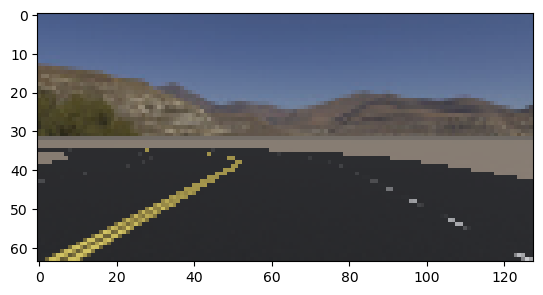

In [ ]:
plt.imshow(img_back)

In [ ]:
# Realizar la predicción
prediction = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:
prediction

array([[-0.00487354]], dtype=float32)

In [ ]:
# Save the model
model.save('behavioral_cloning_model.h5')

In [ ]:
model.save('my_model.keras')